In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
from scipy.constants import pi, c as speed_of_light
import configparser
from tqdm.notebook import tqdm

In [2]:
from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.policies import random_tf_policy
from tf_agents import networks



from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts




from tf_agents.bandits.agents import lin_ucb_agent, neural_linucb_agent, neural_epsilon_greedy_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import matplotlib.pyplot as plt


# Initializing simulation and setup

In [3]:
import sys
sys.path.insert(0,'..')

from utils.custom_configparser import CustomConfigParser

from environments import RIS_TFenv

In [4]:
config = CustomConfigParser(interpolation=configparser.ExtendedInterpolation(),
                            allow_no_value=True,
                            inline_comment_prefixes=('#',))
fin = open('setup_config.ini', 'r')
config.read_file(fin)
config.print()


[pathloss_outdoor]
f0_los     : 24.2 * 10^9
n_los      : 1.98
b_los      : 0
sigma_los  : 3.1
f0_nlos    : 0
n_nlos     : 3.19
b_nlos     : 0
sigma_nlos : 8.2

[pathloss_indoor]
f0_los     : 24.2 * 10^9
n_los      : 3.19
b_los      : 0.06
sigma_los  : 8.29
f0_nlos    : 0
n_nlos     : 1.73
b_nlos     : 0
sigma_nlos : 3.02

[channel_modeling]
q                         : 0.285
l_h                       : 13.2
l_g                       : 13.2
l_siso                    : 0
shadow_fading_exists      : False
wall_attenuation          : 10
normalize_ge              : True
normalize_steering_vector : True
ignore_los                : False
tx_rx_mult_factor         : 0
units_scale               : power

[setup]
environment_type   : outdoor
frequency          : 32 * 10^9
wall_exists        : true
number_of_ris      : 1
ris_elements       : [3,3]
ris_element_groups : [1,1]
transmit_snr       : 5
tx_coordinates     : [0,  30, 2]
ris1_coordinates   : [15, 25, 2]
rx_coordinates     : [30, 30, 1.5]



# Creating an Environment that integrates with RL algorithms

# Buliding generic agent training and evaluation functions

In [5]:
def train_bandit_agent(agent,
                       environment,
                       num_iterations,
                       steps_per_loop=1,
                       batch_size=1,
                       log_interval=20):
    class RewardObserver:
        def __init__(self):
            self.reward_values = np.zeros(num_iterations)
            self.it_cnt = 0

        def __call__(self, trajectory):
            curr_reward = float(trajectory.reward.numpy())
            self.reward_values[self.it_cnt] = curr_reward

            self.it_cnt += 1
            if self.it_cnt % log_interval == 0:
                last_window_rewards = self.reward_values[self.it_cnt - log_interval:self.it_cnt]
                avg_reward = last_window_rewards.mean()
                tqdm.write('Iteration {}: Window avg reward: {}'.format(self.it_cnt,
                                                                   avg_reward))

    reward_observer = RewardObserver()

    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.policy.trajectory_spec,
        batch_size=batch_size,
        max_length=steps_per_loop)

    observers = [replay_buffer.add_batch, reward_observer]

    driver = dynamic_step_driver.DynamicStepDriver(
        env=environment,
        policy=agent.collect_policy,
        num_steps=steps_per_loop * batch_size,
        observers=observers)

    try:
        for _ in tqdm(range(num_iterations)):
            driver.run()
            loss_info = agent.train(replay_buffer.gather_all())
            replay_buffer.clear()

    except KeyboardInterrupt:
        print('Training stopped by user...')

    return reward_observer.reward_values, reward_observer.it_cnt


In [6]:
def plot_training_performance(reward_values, it_cnt, rolling_window, name=None, random_avg_reward=None):

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    name = name if name is not None else 'Trained agent'

    ma_rewards = moving_average(reward_values[:it_cnt], rolling_window)
    plt.figure(figsize=(30,12))
    #plt.plot(range(it_cnt), reward_values[:it_cnt], alpha=.7)
    plt.plot(range(rolling_window-1, it_cnt), ma_rewards, alpha=.7)
    if random_avg_reward is not None:
        plt.hlines([random_avg_reward], 0, it_cnt, color='k', ls=':', lw=5)
        plt.legend([name, 'Random policy'], fontsize=30)
    else:
        plt.legend([name], fontsize=30)

    plt.ylabel('Reward')
    plt.xlabel('Number of Iterations')

    plt.show()

In [7]:
def evaluate_agent(agent_policy, environment, num_timesteps, name=None):
    trained_agent_rewards = np.zeros(num_timesteps)
    time_step = environment.reset()
    for i in range(num_timesteps):
        action = agent_policy.action(time_step)
        time_step = environment.step(action)
        trained_agent_rewards[i] = float(time_step.reward)

    name = name if name is not None else 'Trained agent'

    print('\n\n{} policy average reward: {:2e} ± {:2e}\n'.format(
        name,
        trained_agent_rewards.mean(),
        trained_agent_rewards.std()
    ))

    return trained_agent_rewards.mean()


# Experiments and results

## 0: Random policy

In [8]:
env = RIS_TFenv(config, None, transmit_SNR=1)#10e18)
environment = tf_py_environment.TFPyEnvironment(env)

random_policy = random_tf_policy.RandomTFPolicy(environment.time_step_spec(),
                                                environment.action_spec())

random_avg_reward = evaluate_agent(random_policy, environment, 1000, name='Random')



Random policy average reward: 9.707173e-19 ± 1.056113e-18



## 1: Linear UCB

In [9]:
lucb_agent_name = 'Linear UCB'

env = RIS_TFenv(config, None, transmit_SNR=1)#10e18)
environment = tf_py_environment.TFPyEnvironment(env)

num_actions    = int(2 ** env.N)
num_iterations = 100*num_actions # @param
steps_per_loop = 1  # @param
batch_size     = 1 # @param
log_interval   = 20


observation_spec = environment.observation_spec()
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = environment.action_spec()

lucb_agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                          action_spec=action_spec,
                                          alpha=1,)


reward_values_LUCB, it_cnt_LUCB = train_bandit_agent(lucb_agent, environment, num_iterations, steps_per_loop, batch_size, log_interval)

  0%|          | 0/51200 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
Iteration 20: Window avg reward: 5.496254509328038e-18
Iteration 40: Window avg reward: 4.74310433855061e-18
Iteration 60: Window avg reward: 3.487380324568992e-18
Iteration 80: Window avg reward: 1.7213511890528328e-18
Iteration 100: Window avg reward: 1.890932512491718e-18
Iteration 120: Window avg reward: 1.1447150213091387e-18
Iteration 140: Window avg reward: 1.1351779226813122e-18
Iteration 160: Window avg reward: 2.2878966319200534e-18
Iteration 180: Window avg reward: 1.6277463699802615e-18
Iteration 200: Window avg reward: 8.539610687527785e-19
Iteration 220: Window avg reward: 8.136907653309925e-19
Iteration 240: Window avg reward: 7.201871713549

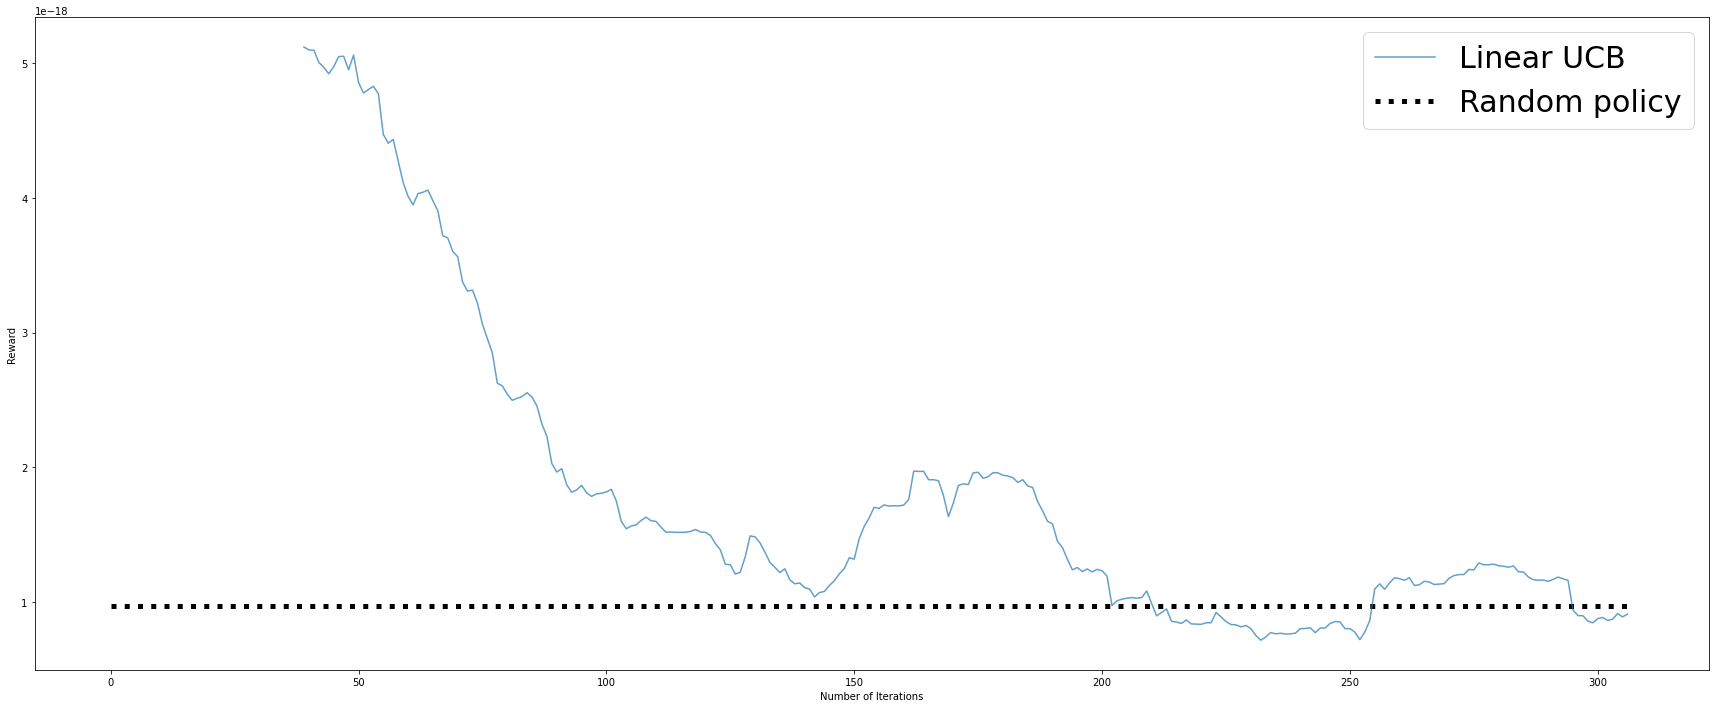



Linear UCB policy average reward: 8.949619e-19 ± 6.980710e-19



8.949619038411243e-19

In [11]:
plot_training_performance(reward_values_LUCB, it_cnt_LUCB, 2*log_interval, lucb_agent_name, random_avg_reward)
evaluate_agent(lucb_agent.policy, environment, 20, lucb_agent_name)

# 2: Neural Linear UCB Agent

In [12]:
nlucb_agent_name = 'Neural LinUCB'

env = RIS_TFenv(config, None, transmit_SNR=1)#10e18)
environment = tf_py_environment.TFPyEnvironment(env)

num_actions = int(2 ** env.N)
num_iterations = 100 * num_actions  # @param
steps_per_loop = 1  # @param
batch_size = 1  # @param
log_interval = 20

encoding_dim = 64
learning_rate = 10e-3

observation_spec = environment.observation_spec()
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = environment.action_spec()

observation_dim = environment.observation_spec().shape.as_list()[0]


encoding_network = networks.encoding_network.EncodingNetwork(
    input_tensor_spec = observation_spec,
    fc_layer_params   = (100,100,encoding_dim),
)


nlucb_agent = neural_linucb_agent.NeuralLinUCBAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    encoding_network=encoding_network,
    encoding_network_num_train_steps=2000,
    encoding_dim=encoding_dim,
    epsilon_greedy=0.1,
    alpha=5,
    gamma=0.5,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),

)

reward_values_NLUCB, it_cnt_NLUCB = train_bandit_agent(nlucb_agent, environment, num_iterations, steps_per_loop, batch_size, log_interval)

  0%|          | 0/51200 [00:00<?, ?it/s]

Iteration 20: Window avg reward: 1.1148657232192805e-18
Iteration 40: Window avg reward: 2.1867384247161813e-18
Iteration 60: Window avg reward: 3.6501484470996415e-18
Iteration 80: Window avg reward: 4.212672932859058e-18
Iteration 100: Window avg reward: 4.286525699631814e-18
Iteration 120: Window avg reward: 4.8890337224198674e-18
Iteration 140: Window avg reward: 3.6226150473239335e-18
Iteration 160: Window avg reward: 4.4589772267051584e-18
Iteration 180: Window avg reward: 4.254666598424645e-18
Iteration 200: Window avg reward: 4.146822405197752e-18
Iteration 220: Window avg reward: 5.0232251154827304e-18
Iteration 240: Window avg reward: 3.7427631220932574e-18
Iteration 260: Window avg reward: 4.451273789303211e-18
Iteration 280: Window avg reward: 3.806834047891721e-18
Iteration 300: Window avg reward: 4.199044846631441e-18
Iteration 320: Window avg reward: 5.145720019587728e-18
Iteration 340: Window avg reward: 5.389360321402435e-18
Iteration 360: Window avg reward: 4.11930619

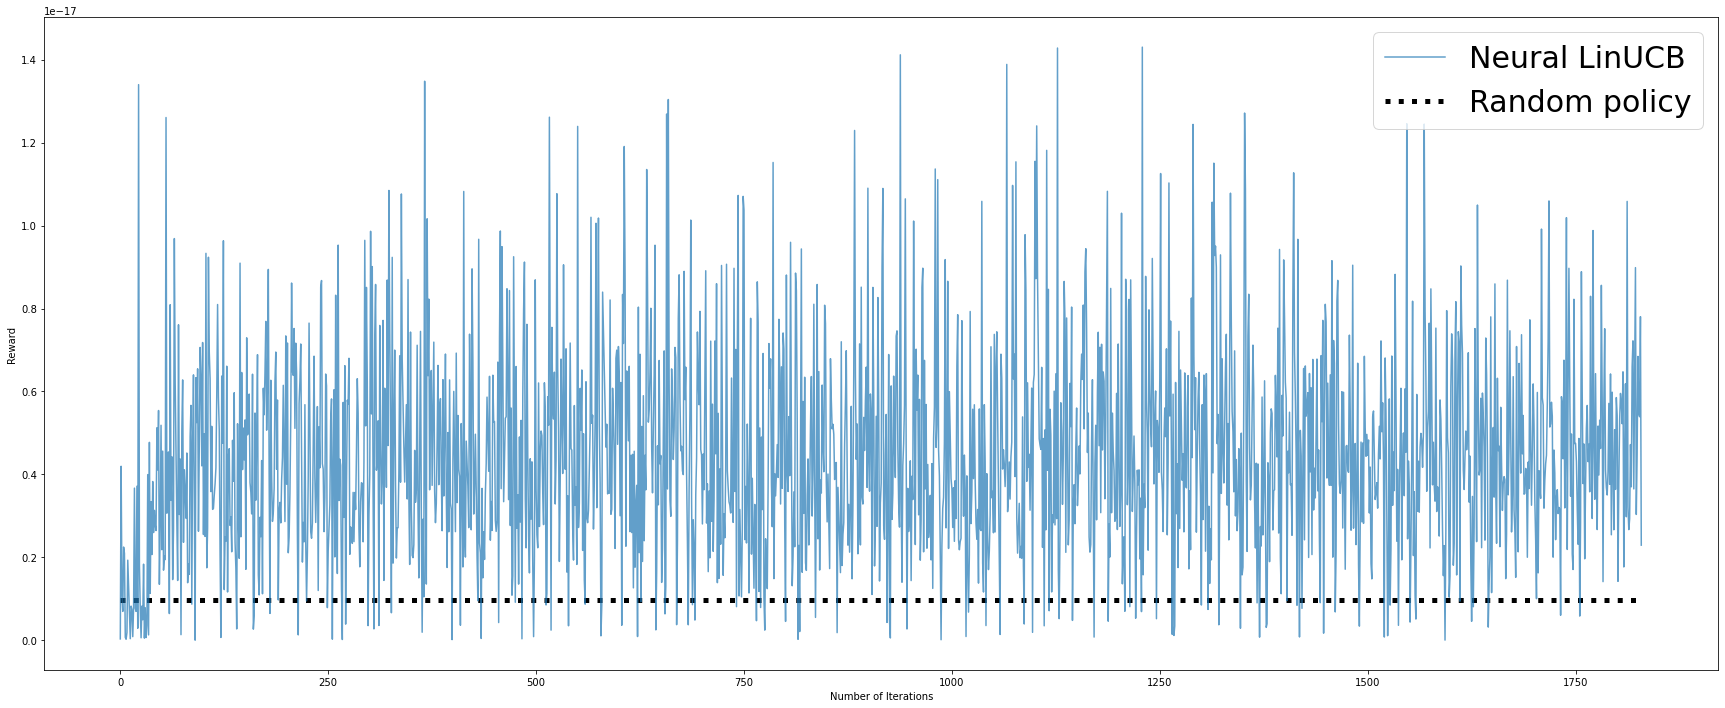



Neural LinUCB policy average reward: 5.005062e-18 ± 1.931289e-18



5.005062078108982e-18

In [14]:
plot_training_performance(reward_values_NLUCB, it_cnt_NLUCB, 1, nlucb_agent_name, random_avg_reward)
evaluate_agent(nlucb_agent.policy, environment, 20, nlucb_agent_name)